In [ ]:
import logging
import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

import lightning as pl

from calvera.bandits import DiagonalPrecApproxLinearTSBandit
from calvera.utils import TopKSelector
from calvera.benchmark import BanditBenchmarkEnvironment
from calvera.benchmark.datasets import SyntheticCombinatorialDataset

c:\Users\Parisa\anaconda3\envs\calvera\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Context shape: torch.Size([20, 80])
Reward shape: torch.Size([20])

Rewards: [0.0009425383759662509, 0.01591693051159382, 0.0020510931499302387, 0.010034953244030476, 3.051970270462334e-05, 0.005022116005420685, 0.007191677577793598, 0.0016485119704157114, 0.006944944150745869, 0.01584775559604168, 0.029920300468802452, 2.3011356461211108e-05, 0.0015777185326442122, 0.029857859015464783, 0.0005690084653906524, 0.00090129638556391, 9.238207894668449e-06, 0.003150854492560029, 2.8514810765045695e-05, 0.020021598786115646]

Top 4 arms: [10, 13, 19, 1]
Top 4 rewards: [0.029920300468802452, 0.029857859015464783, 0.020021598786115646, 0.01591693051159382]


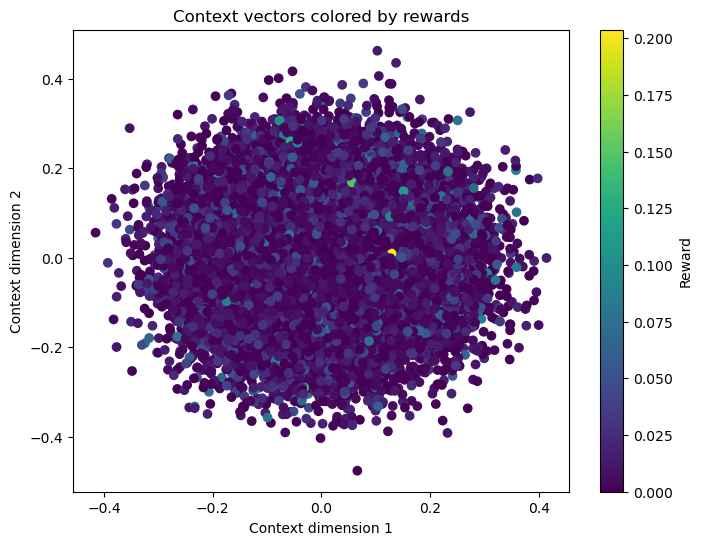

In [2]:
dataset = SyntheticCombinatorialDataset(
    n_samples=2000, num_actions=20, context_size=80, function_type="quadratic", seed=42
)

contexts, rewards = dataset[0]
print(f"\nContext shape: {contexts.shape}")
print(f"Reward shape: {rewards.shape}")

print(f"\nRewards: {rewards[:].tolist()}")

K = 4
top_k_indices = torch.topk(rewards, K).indices
print(f"\nTop {K} arms: {top_k_indices.tolist()}")
print(f"Top {K} rewards: {rewards[top_k_indices].tolist()}")

# plot first two dimensions of X and color by y
plt.figure(figsize=(8, 6))
plt.scatter(
    dataset.contexts.view(-1, dataset.context_size)[:, 0],
    dataset.contexts.view(-1, dataset.context_size)[:, 1],
    c=dataset.rewards.view(-1, dataset.context_size)[:],
    cmap="viridis",
)
plt.xlabel("Context dimension 1")
plt.ylabel("Context dimension 2")
plt.title("Context vectors colored by rewards")
plt.colorbar(label="Reward")

In [ ]:
K = 4

accelerator = "cpu"
train_loader = DataLoader(dataset, batch_size=100, shuffle=True)
env = BanditBenchmarkEnvironment(train_loader)

bandit_module = DiagonalPrecApproxLinearTSBandit(
    n_features=dataset.context_size,
    selector=TopKSelector(k=K),
    lazy_uncertainty_update=True,
).to(accelerator)

logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.FATAL)

In [4]:
rewards = np.array([])
regrets = np.array([])
progress = tqdm(iter(env), total=len(env))

for contextualized_actions in progress:
    chosen_actions, _ = bandit_module.forward(contextualized_actions)

    trainer = pl.Trainer(
        max_epochs=1,
        log_every_n_steps=1,
        enable_progress_bar=False,
        enable_model_summary=False,
        enable_checkpointing=False,
        accelerator=accelerator,
    )

    chosen_contextualized_actions, realized_scores = env.get_feedback(chosen_actions)
    realized_rewards = realized_scores.sum(dim=1)
    batch_regret = env.compute_regret(chosen_actions)

    rewards = np.append(rewards, realized_rewards.cpu().numpy())
    regrets = np.append(regrets, batch_regret.cpu().numpy())

    progress.set_postfix(
        reward=realized_rewards.mean().item(),
        regret=batch_regret.mean().item(),
        avg_regret=np.mean(regrets),
        acc_regret=np.sum(regrets),
    )

    bandit_module.record_feedback(chosen_contextualized_actions, realized_scores)
    trainer.fit(bandit_module)
    bandit_module = bandit_module.to(accelerator)

metrics = pd.DataFrame(
    {
        "reward": rewards,
        "regret": regrets,
    }
)

metrics.head()

  0%|          | 0/20 [00:00<?, ?it/s, acc_regret=9.19, avg_regret=0.0919, regret=0.0919, reward=0.0447]c:\Users\Parisa\anaconda3\envs\calvera\lib\site-packages\lightning\pytorch\core\optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
c:\Users\Parisa\anaconda3\envs\calvera\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
100%|██████████| 20/20 [00:01<00:00, 10.93it/s, acc_regret=138, avg_regret=0.0692, regret=0.0557, reward=0.0905] 


,reward,regret
0,0.016614,0.059906
1,0.111069,0.091257
2,0.047188,0.077208
3,0.021675,0.067737
4,0.048148,0.041577


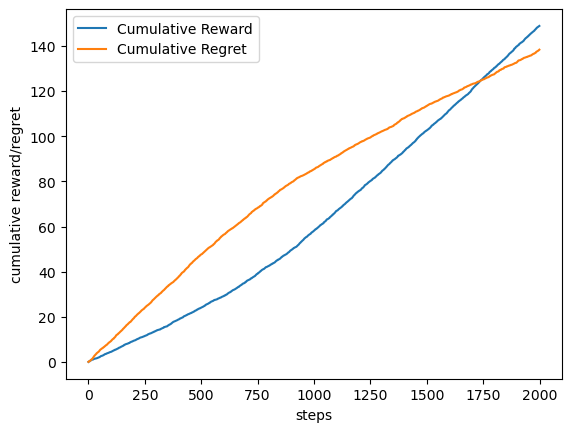

In [5]:
# Calculate cumulative metrics
cumulative_reward = np.cumsum(metrics["reward"])
cumulative_regret = np.cumsum(metrics["regret"])

# Plot cumulative reward and regret
plt.plot(cumulative_reward, label="Cumulative Reward")
plt.plot(cumulative_regret, label="Cumulative Regret")
plt.xlabel("steps")
plt.ylabel("cumulative reward/regret")
plt.legend()
plt.show()

In [6]:
print(f"Average reward (first 10 rounds): {np.mean(metrics['reward'][:10]):.4f}")
print(f"Average reward (first 100 rounds): {np.mean(metrics['reward'][:100]):.4f}")
print(f"Average reward (all rounds): {np.mean(metrics['reward']):.4f}")
print("")
print(f"Average regret (first 10 rounds): {np.mean(metrics['regret'][:10]):.4f}")
print(f"Average regret (first 100 rounds): {np.mean(metrics['regret'][:100]):.4f}")
print(f"Average regret (all rounds): {np.mean(metrics['regret']):.4f}")

Average reward (first 10 rounds): 0.0605
Average reward (first 100 rounds): 0.0447
Average reward (all rounds): 0.0744

Average regret (first 10 rounds): 0.0667
Average regret (first 100 rounds): 0.0919
Average regret (all rounds): 0.0692
